# How Machines Learn

_Disclaimer_: Math and code ahead, Don't be afraid!

This presentation is heavily Inspired by: [3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk)

## Tooling Setup

Setting up some tooling here, feel free to ignore me :)

In [ ]:
# Install Manim -- This doesn't seem to work...
# !sudo apt update
# !sudo apt install libcairo2-dev ffmpeg \
#     texlive texlive-latex-extra texlive-fonts-extra \
#     texlive-latex-recommended texlive-science \
#     tipa libpango1.0-dev
# !pip install manim
# !pip install IPython --upgrade

In [ ]:
# Download mnist data
!wget https://github.com/m-triassi/ml-exercises/raw/master/Lab%208/mnist_train.npz
!wget https://github.com/m-triassi/ml-exercises/raw/master/Lab%208/mnist_test.npz


--2023-07-27 15:16:17--  https://github.com/m-triassi/ml-exercises/raw/master/Lab%208/mnist_train.npz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m-triassi/ml-exercises/master/Lab%208/mnist_train.npz [following]
--2023-07-27 15:16:17--  https://raw.githubusercontent.com/m-triassi/ml-exercises/master/Lab%208/mnist_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9861168 (9.4M) [application/octet-stream]
Saving to: ‘mnist_train.npz’

mnist_train.npz     100%[===================>]   9.40M  --.-KB/s    in 0.09s   

2023-07-27 15:16:18 (103 MB/s) - ‘mnist_train.npz’ saved [9861168/986116

In [ ]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn
import sklearn.preprocessing     # For StandardScaler
import sklearn.linear_model      # For LogisticRegression
import sklearn.neural_network    # For MLPClassifier
import torch
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)  # Annoying
np.set_printoptions(precision=3, suppress=True)  # Print array values as 0.0023 instead of 2.352e-3

In [ ]:
# Define some helper functions
def plot_matrix_grid(V):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    """
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmin, vmax = np.percentile(V, [0.1, 99.9])   # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=vmin, vmax=vmax, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right

def plot_single_num(t):
  image = np.reshape(t, (28, 28))

  # Create a plot showing the pixel values and darkness levels of the image
  fig, ax = plt.subplots()
  im = ax.imshow(image, cmap='gray')

  # Add a colorbar showing the darkness levels
  cbar = ax.figure.colorbar(im, ax=ax)

  # Set the title and axis labels
  ax.set_title('MNIST Grayscale Image')
  ax.set_xlabel('Pixel Column')
  ax.set_ylabel('Pixel Row')

  # Show the plot
  plt.show()


## Introduction

What will we be covering?
- Why our brains are amazing
- How does this inform machine learning?
- Whats really going on when a model answers a question? (inferrence)
- How does it "learn" to do this?


The focus is on intuition over complex technical details

## Our brains are amazing!

Lets back up for a second and do something very simple

Identify the picture we're looking at:

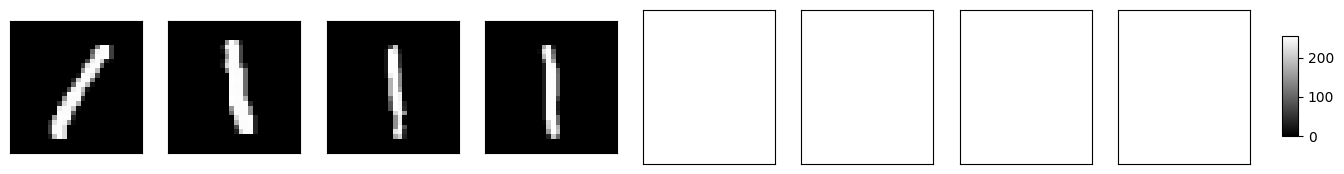

In [ ]:
# Load our data
X_train = []
y_train = []

with np.load("mnist_train.npz") as data:
    X_train = data['X']
    y_train = data['y']

# Load test data
X_test = []
y_test = []

with np.load("mnist_test.npz") as data:
    X_test = data['X']
    y_test = data['y']

# Display first example set
what_is = [X_train[3], X_train[6], X_train[8], X_train[14]]
plot_matrix_grid(np.reshape(what_is, (4, 28, 28)))

These could be anything!

What if i helped out and did this:

What are we looking at now?

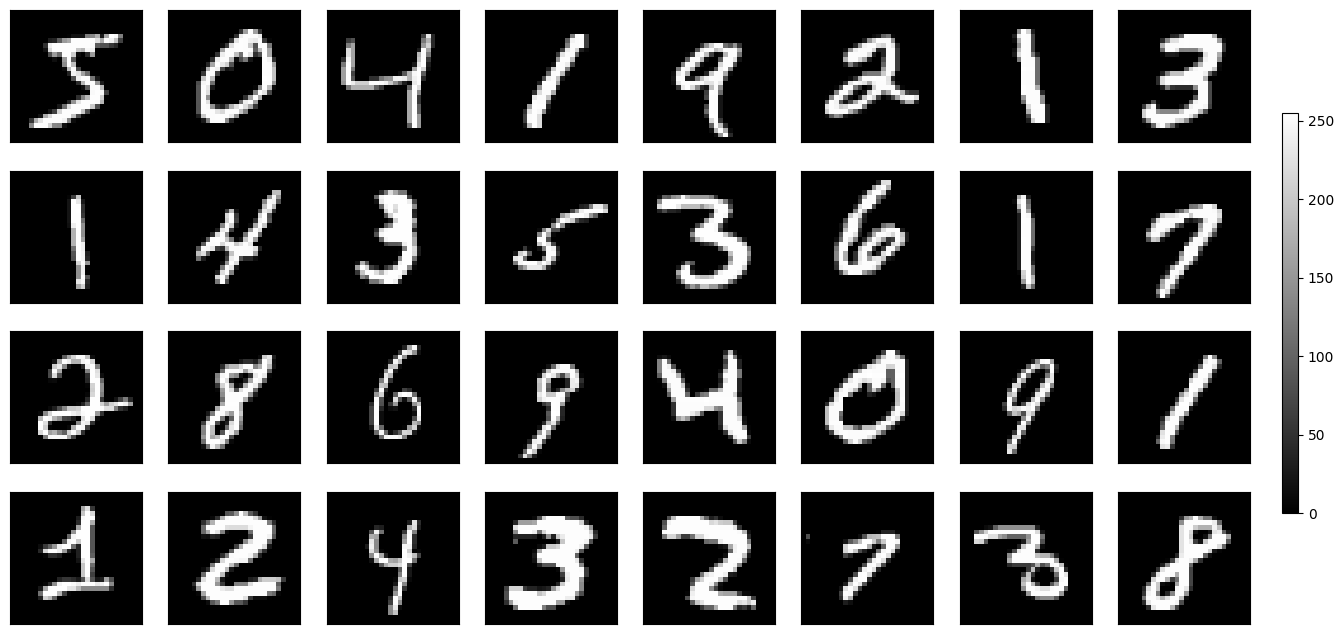

In [ ]:
plot_matrix_grid(np.reshape(X_train, (60000, 28, 28)))

Why is the task so much easier now?

There's lots of valid reasons but one might be:

Context! Given enough contextual information our brain will fire a particular set of neurons that help with this task automatically.

Lets appreciate this for a second.

The same number shows up here multiple times, and they always look different. Yet, we have no trouble picking out a 4 or a 6 from each other

## How would a computer do this?

Before we get to machine learning, lets try and write a piece of software that can identify these images of numbers, deterministically.

Suddenly a task that was quite simple becomes incredibly difficult.

But we're all smart! Lets take a look at a piece of our data and see what we can do.

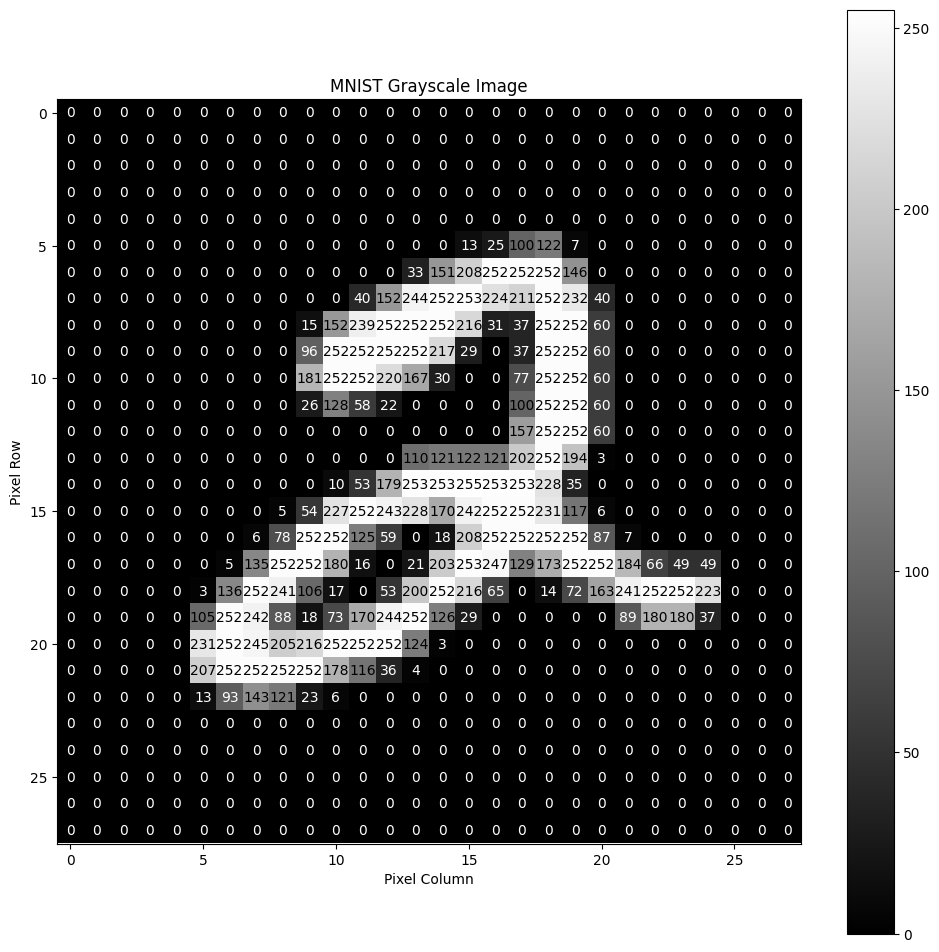

In [ ]:
# Pick a number from the data set
image = np.reshape(X_train[5], (28,28))

# Create a plot showing the pixel values and darkness levels of the image
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(image, cmap='gray')

# Add a colorbar showing the darkness levels
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over each pixel in the image and add the pixel intensity value as text inside the pixel
for i in range(28):
    for j in range(28):
        color = 'w' if image[i, j] < 100 else 'black'
        ax.text(j, i, str(image[i, j]), ha='center', va='center', color=color)

# Set the title and axis labels
ax.set_title('MNIST Grayscale Image')
ax.set_xlabel('Pixel Column')
ax.set_ylabel('Pixel Row')

# Show the plot
plt.show()

In [ ]:
def num_search(input_num):
  sums = []

  for compare in X_train:
    sums.append(sum(compare - input_num))

  return sums.index(min(sums))

matching = num_search(X_train[5])

print(f"your number is a: {str(y_train[matching])}!")

your number is a: 2!


In the above scenario there was an exact match between our input and one of our examples, does it still work when that isn't the case?

Input number:


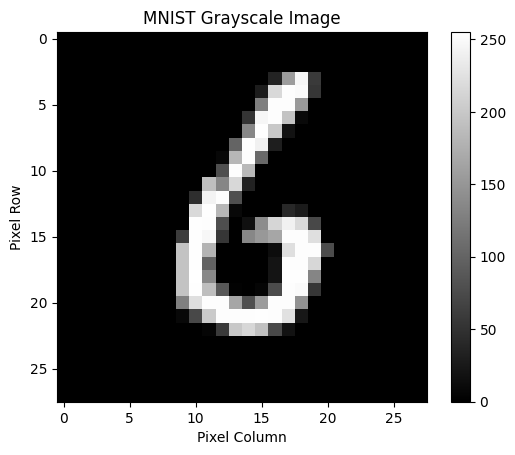


Closest Matching number:


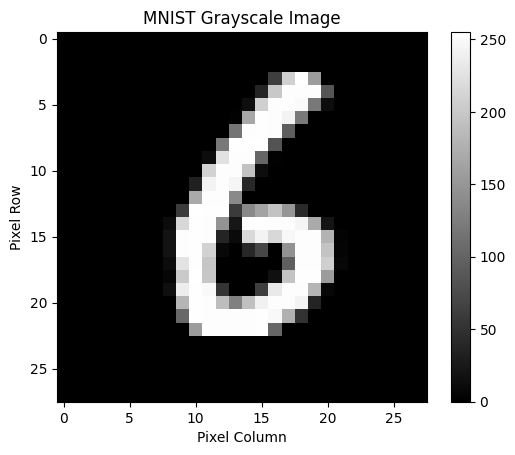

your number is a: 6


In [ ]:
# Show the target number first
target_num = X_test[50]
# target_num = X_test[245]
print("Input number:")
plot_single_num(target_num)

matching = num_search(target_num)
print("\nClosest Matching number:")
plot_single_num(X_train[matching])
print(f"your number is a: {str(y_train[matching])}")

### Is this what the brain does?

Not really!

So then how can we inform a structure that will enable us to be more accrutate _and_ more efficient?

What if we had a structure where we had lots of "nodes" (or "neurons"), that held a number, that were wired together, and any node would "activate" if the nodes connected to it would _excite_ it enough

#### Excited? Neuron? What???

- **Neurons**: These Hold some number.

- **Excited**: The value of the neuron is close to "1"

For this to work we would need that to look like as a mathematical model, how can we represent that?

_NB:_ While we are using the structure of the brain to inform some of our design descisions here, its important to note, this _isnt_ a brain, and we wont even approach 1/100th the complexity of a brain, this is just some math!

## How does a machine "think"?

Lets go back to highschool math!

Remember weighted sums?

$y = w_1a_1+w_2a_2+...+w_na_n$

where:
- $w_n$ is the weight
- $a_n$ is the "activation" or the result in that neuron

What if i told you this is all it takes?

The function above is how we calculate if a node is excited, and by excited we just mean the value is close to 1 rather than 0.


_nb:_ im handwaving away some of the math, but we're not far off here.

#### Lets look at a video of what i mean...

[Neural net inferrence](https://giant.gfycat.com/LimpingDarlingFinnishspitz.mp4)

The number in the node or neuron is $a_n$ and the line connecting the 2 nodes has a number assigned to it, that we call the _weight_, thats $w_n$

Whats going on here? Effectively every one of those circles is calculating that above formula to determine if it should be activated or not!

We repeat until we reach the end.

#### Input
To start we use the input image to determine our initial state, for a 28x28, image, thats 784 inputs.

#### Output
Our last "layer" in the network will represent our 10 potential lables for the number, Ie: 0-9

#### "Hidden" layers
There are also some layers in-between the input and outputs, i'll touch on those at the end, but for now we can think of these layers as ones that will encode some patterns that are helpful for detection in their weights.

The choices in these layers are sort of arbitrary.

## Sounds easy, enough lets try it!

1/1 [==============================] - 0s 180ms/step
i am 100.0% sure this is a 0
i am 25.29% sure this is a 1
i am 100.0% sure this is a 2
i am 0.0% sure this is a 3
i am 100.0% sure this is a 4
i am 0.0% sure this is a 5
i am 0.0% sure this is a 6
i am 100.0% sure this is a 7
i am 99.87% sure this is a 8
i am 43.57% sure this is a 9


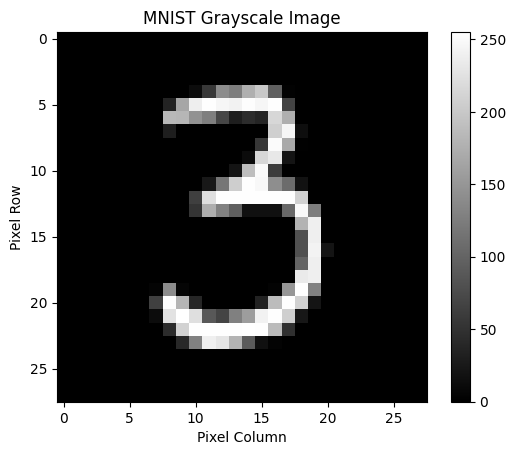

In [ ]:
# Define our model architecture, this should match the graph we have.
inputs = keras.Input(shape=(28*28,), batch_size=1)
FFNNlayer1 = keras.layers.Dense(16, activation='relu')(inputs)
FFNNlayer2 = keras.layers.Dense(16, activation='relu')(FFNNlayer1)
output = keras.layers.Dense(10, activation='sigmoid')(FFNNlayer2)

hyperparameters = keras.Model(inputs=inputs, outputs=output, name="hyperparameters")
# hyperparameters.summary()

# Make some labels so we can print our results easily later
labels = list(range(0, 10))
# Ask our network to identify a number
inferrence = hyperparameters.predict(np.reshape(X_train[50], (1,-1)))

# Print out the predicitons about what number it might be
results = dict(zip(labels, inferrence.tolist()[0]))
for label, prediction in results.items():
  print(f"i am {round(prediction*100, 2)}% sure this is a {label}")

plot_single_num(X_train[50])

### Weird!
What's going on here?



We forgot about a critical step, training!

How does that work? Heres [a diagram](https://giant.gfycat.com/ContentDarlingCub.mp4) to help visualize


### Cost and Backpropagation
Training and its theory is really where all the complex math can be found in machine learning.

Rather than talk about it in-depth, lets get an intuition for whats happening.

Cost is really just the difference between the number we got out of the network and the desired numbers we wanted.

Once we've built a cost we can use math to adjust the _weights_ of each connection based on how wrong they were. The more incorrect a particular output was the more the weights for that neuron get adjusted

Heres a couple of visualizations that might help: [All layers](https://giant.gfycat.com/BitesizedWeeBlacklemur.mp4), [One-by-one](https://giant.gfycat.com/EquatorialSpicyEgg.mp4)

## What does adjusting the weights do?

When we use backpropagation to adjust the weights, we're telling the network "focus **here**".

We allow the network, via math, to determine what the important features that make up a number are.

Lets look at [a concrete example](https://giant.gfycat.com/BabyishGeneralFruitfly.mp4) or [two](https://giant.gfycat.com/GlitteringCavernousGoosefish.mp4)



Effectively our hope is that the network might choose a particular feature of a number, like a straigh line, and have 1 neuron focus on detecting that. It does that by giving a higher weight to the area where that line might be, and a negative weight to the area outside the line, to ensure its empty.

If you're sharp-eyed, you might have noticed an extra term there, the _bias_ that just helps inform the network how important that neuron specifically is to the overall result.

## Lets train a network!

In [ ]:
# Normalize our data. This helps make sure everything is between 0 and 1
X_train_norm = sklearn.preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test_norm = sklearn.preprocessing.StandardScaler().fit(X_test).transform(X_test)


# Define our network architecture and run a training session
# Run our training for 20 iterations of 100 numbers each iteration
mlpc17 = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(16,16), activation='tanh', solver='sgd',
                                              batch_size=100, max_iter=10, learning_rate_init=0.01, momentum=0.9,
                                              random_state=0, verbose=True).fit(X_train_norm, y_train)

# Print our error rate, ie: how often is our network wrong?
print("\n%.2f%% training error" % ((1-mlpc17.score(X_train_norm, y_train))*100))
print("%.2f%% testing error" % ((1-mlpc17.score(X_test_norm, y_test))*100))

Iteration 1, loss = 0.53977240
Iteration 2, loss = 0.27749351
Iteration 3, loss = 0.23572665
Iteration 4, loss = 0.21376778
Iteration 5, loss = 0.19742507
Iteration 6, loss = 0.18569699
Iteration 7, loss = 0.17654796
Iteration 8, loss = 0.16925160
Iteration 9, loss = 0.16281504
Iteration 10, loss = 0.15948159

4.11% training error
6.67% testing error


### So does it work?

We can run a few tests, but the above numbers are showing us that our neural network is right ~93% of the time. thats pretty good for 20 seconds of learning!

Lets get a few visual examples:

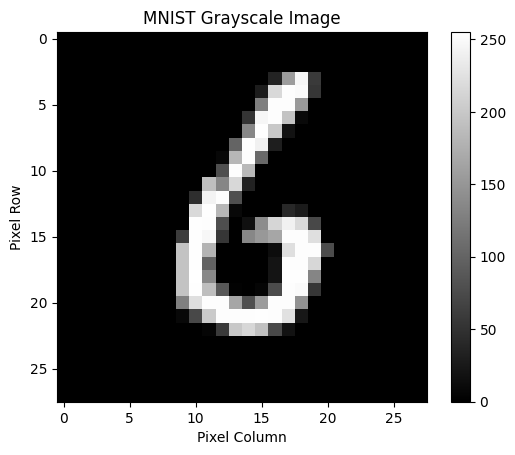



I think the number is a: 6


In [ ]:
idx = 50
# idx = 80
# idx = 240
target = X_test_norm[idx]

plot_single_num(X_test[idx])

prediction = mlpc17.predict(np.reshape(target, (1,-1)))

print(f"\n\nI think the number is a: {prediction[0]}")

## Lets look at their brains!

We can actually visualize what the "brain" of a machine learning model looks like by graphing the weights of each layer, like we saw in the visualizations before.

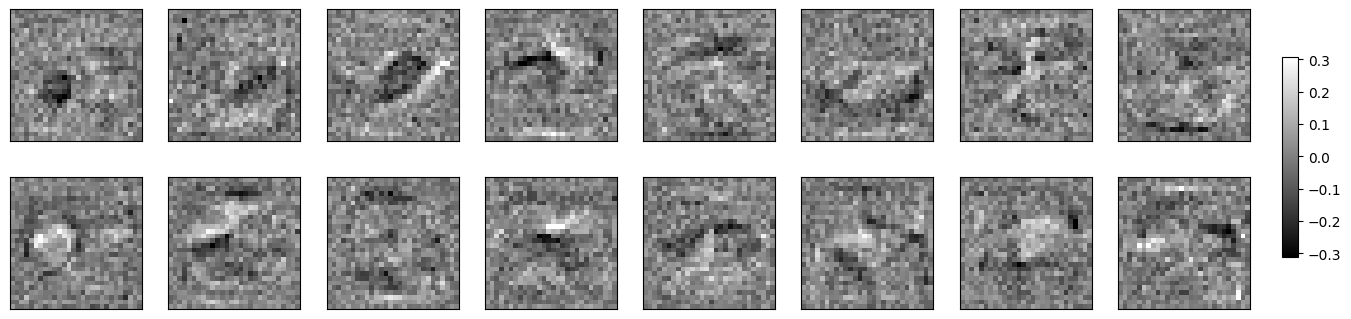

In [ ]:
plot_matrix_grid(np.reshape(np.array(mlpc17.coefs_[0]).T, (16, 28, 28)))

### Sort of confusing, right?

This is what AI experts mean when we dont understand how AI works, or why it works.

Theres no real dicernable pattern that tells us "oh its looking for a loop here, and a line here". _Not_ that AI might be sentient or about to take over the world.

Their brains are just a collection of numbers we use to do some addition, subtraction, and multiplication with 🙂

## Summarized

So, if we had to put it into a couple senteces, what's a machine learning algorithm doing, at its base?


Anyone want to try?


---

We're just using some math to encode some patterns, be it visual, auditory, or otherwise into a set of numbers we can use to help identify things generally or to generate new data that looks similar to what it was trained on  

## Questions?


### Extra resources
3Blue1Brown:

- https://www.youtube.com/watch?v=aircAruvnKk
- https://www.youtube.com/watch?v=IHZwWFHWa-w
- https://www.youtube.com/watch?v=Ilg3gGewQ5U
- https://www.youtube.com/watch?v=tIeHLnjs5U8

Exercises i've done in the past for this:
- https://github.com/m-triassi/ml-exercises/blob/master/Lab%208/lab8-exercises.ipynb

